<a href="https://colab.research.google.com/github/Nourbh17/Hyperspectral-image-Classification/blob/main/Hyperspectral_image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


from scipy import io as spio
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import random
import seaborn as sns
import plotly.express as px
import spectral

# load data
def input_data_load(DATA_DIR, key):
    data = spio.loadmat(DATA_DIR)
    return data[key]



def visualize_bands(X):
  sns.axes_style('whitegrid')
  fig = plt.figure(figsize = (12, 6))

  for i in range(1, 7):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,i*10+30], cmap='jet')
    plt.axis('off')
    plt.title(f'band - {i*10+30}')



def display_dataset(img,  bands):

    # Select RGB bands
    rgb_img = img[:, :, bands]

    # Display the image
    spectral.imshow(rgb_img)


# colormap
def colormap(kinds):
    cdict = ['#FFFFFF', '#FFDEAD', '#FFC0CB', '#FF1493', '#DC143C', '#FFD700', '#DAA520',
             '#D2691E', '#FF4500', '#00FA9A', '#00BFFF', '#6495ED', '#9932CC', '#8B008B',
             '#228B22', '#000080', '#808080']
    cdict = cdict[:kinds]
    return colors.ListedColormap(cdict, 'indexed')


def dis_groundtruth(gt, title):
    plt.figure(title)
    plt.title(title)
    kinds = np.unique(gt).shape[0]
    plt.imshow(gt, cmap = colormap(kinds))
    plt.colorbar()






In [ ]:
!pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
class Hyperspectralimage(object):
    def __init__(self, data, label):
        self.Weight = data.shape[0]
        self.Height = data.shape[1]
        self.Bands = data.shape[2]
        self.Kinds = np.unique(label).shape[0]
        self.data = data
        self.label = label




    def normlize(self):
        x = np.zeros(shape = self.data.shape, dtype = 'float64')
        for i in range(self.Bands):
            temp = self.data[:, :, i]
            mean =  np.mean(temp)
            std = np.std(temp)
            x[:, :, i] = ((temp-mean)/std)
        return x



    def batch_select(self, pct):
        test_pixels = self.label.copy()
        train_pixels = self.label.copy()
        for i in range(self.Kinds-1):
            num = np.sum(self.label == (i+1))
            train_num = (num*pct)//100
            if train_num < 10:
                train_num = 10
            temp1 = np.where(self.label == (i+1))             #get all the i samples which has num number
            temp2 = random.sample(range(num), train_num)      #get random sequence
            for i in temp2:
                test_pixels[temp1[0][temp2],temp1[1][temp2]] = 0
        train_pixels = self.label - test_pixels
        return train_pixels, test_pixels




def get_2dimbatches(input_data, label_select) :
   pixel_num = np.sum(label_select != 0) #number of pixels per label
   kind = np.unique(label_select).shape[0]-1 #the number of unique classes in label_select, excluding the background class
   size_2dim = int(np.sqrt(input_data.shape[2]))
   reshape_band = pow(size_2dim, 2)
   batch_out = np.zeros([pixel_num, size_2dim, size_2dim]) #initializes an array to store the batches of input data
   batch_label = np.zeros([pixel_num, kind]) #This initializes an array to store the corresponding labels for each batch.
   pixel = np.where(label_select != 0) #This finds the indices where the labels are not 0, effectively finding the indices of the labeled pixels.
   for i in range(pixel_num):
       batch_out[i, :, :] = np.reshape(input_data[pixel[0][i], pixel[1][i], :reshape_band], (size_2dim, size_2dim))
       temp = (label_select[pixel[0][i],pixel[1][i]]-1)
       batch_label[i, temp] = 1
   batch_out = batch_out.swapaxes(1,2)
   batch_out = batch_out[:, :, :, np.newaxis]
   return batch_out, batch_label


# **Loading** **Data**

In [ ]:

PAVIADATA_DIR = '/content/drive/MyDrive/Pavia.mat'
PAVIAGT_DIR = '/content/drive/MyDrive/Pavia_gt.mat'

# Pavia Center data
pavia_origin_data = input_data_load(PAVIADATA_DIR, 'pavia')
pavia_gt = input_data_load(PAVIAGT_DIR, 'pavia_gt')
hyperdate = Hyperspectralimage(pavia_origin_data, pavia_gt)
gt_data = pavia_gt





In [ ]:
pavia_gt

In [ ]:
pavia_origin_data

In [ ]:
''' get the type and shape of the data and visualize it'''
print (type(pavia_origin_data))       # <class 'numpy.ndarray'>
print (pavia_origin_data.shape)       # (1096, 715, 102)
print (np.unique(gt_data))  #[0~9]

<class 'numpy.ndarray'>
(1096, 715, 102)
[0 1 2 3 4 5 6 7 8 9]


**Data Visualization:**
The visualize_bands function visualizes different spectral bands of the hyperspectral image data

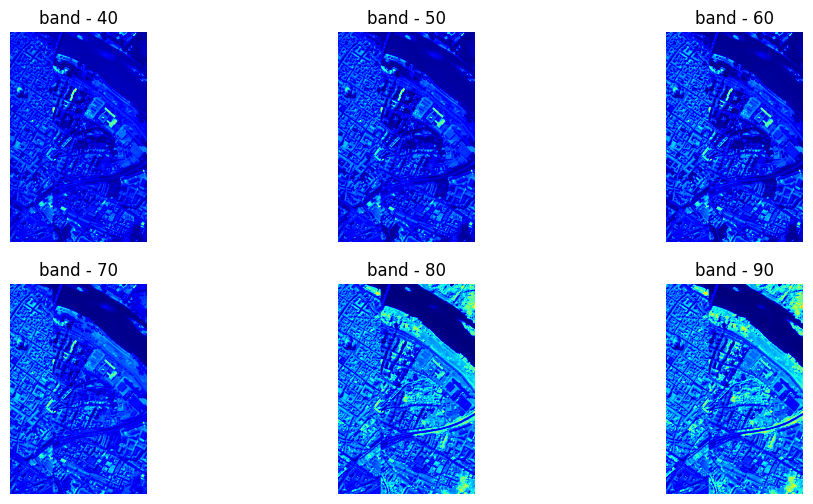

In [ ]:
visualize_bands(pavia_origin_data)

**Displaying Dataset:**
The display_dataset function displays the RGB image of the hyperspectral data.

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


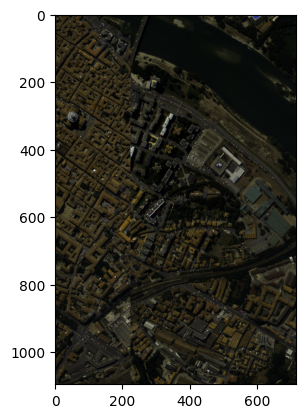

In [ ]:
display_dataset(pavia_origin_data,(55, 41, 12))

**Creating Colormap for Ground Trut**h:
The colormap function creates a colormap for visualizing ground truth labels.

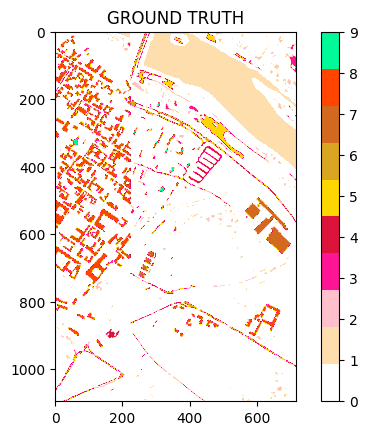

In [ ]:
dis_groundtruth(gt_data, "GROUND TRUTH")

**Normalization and Batch Selection**

In [ ]:

norm_data = hyperdate.normlize()



In [ ]:
norm_data.shape

(1096, 715, 102)

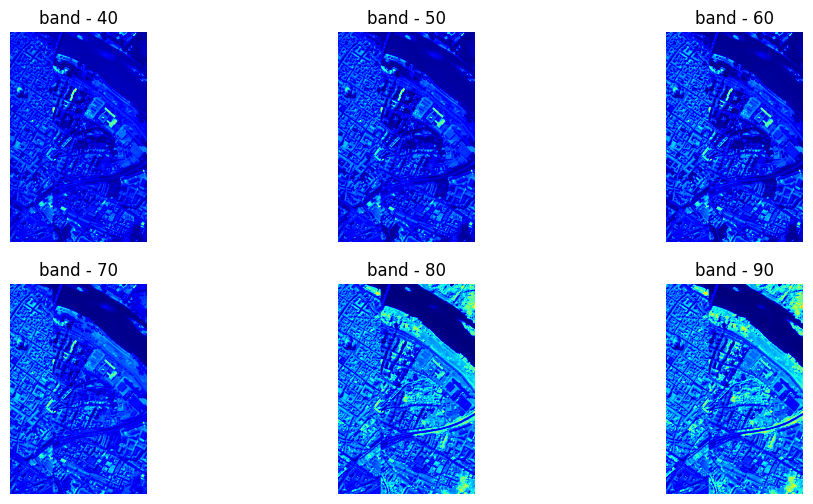

In [ ]:
visualize_bands(norm_data)

# **Applying** **PCA**

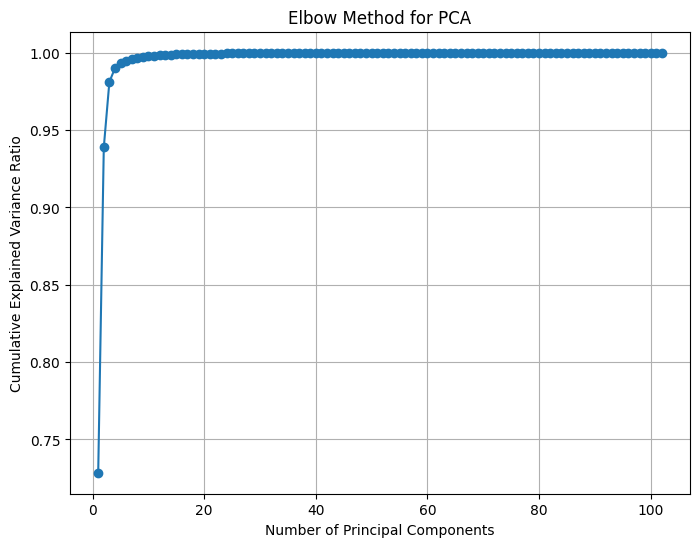

In [ ]:
# Perform PCA for different values of k
pca = PCA()
pavia_centre_flattened = norm_data.reshape(-1, norm_data.shape[-1])
pca.fit(pavia_centre_flattened)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Elbow Method for PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def dimension_PCA(data, input_dimension):
    # Reshape the data into a 2D array (samples x features)
    num_samples, num_features, num_bands = data.shape
    flattened_data = data.reshape(num_samples * num_features, num_bands)

    # Apply PCA to the flattened data
    pca = PCA(n_components=input_dimension)
    transformed_data=pca.fit_transform(flattened_data)


    whole_pca = transformed_data.reshape(num_samples, num_features, input_dimension)

    return whole_pca,transformed_data

In [ ]:
pavia_centre_pca,a = dimension_PCA(norm_data,6)

In [ ]:
print(pavia_centre_pca.shape)

(1096, 715, 5)


<ipython-input-85-a44f5cca1930>:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


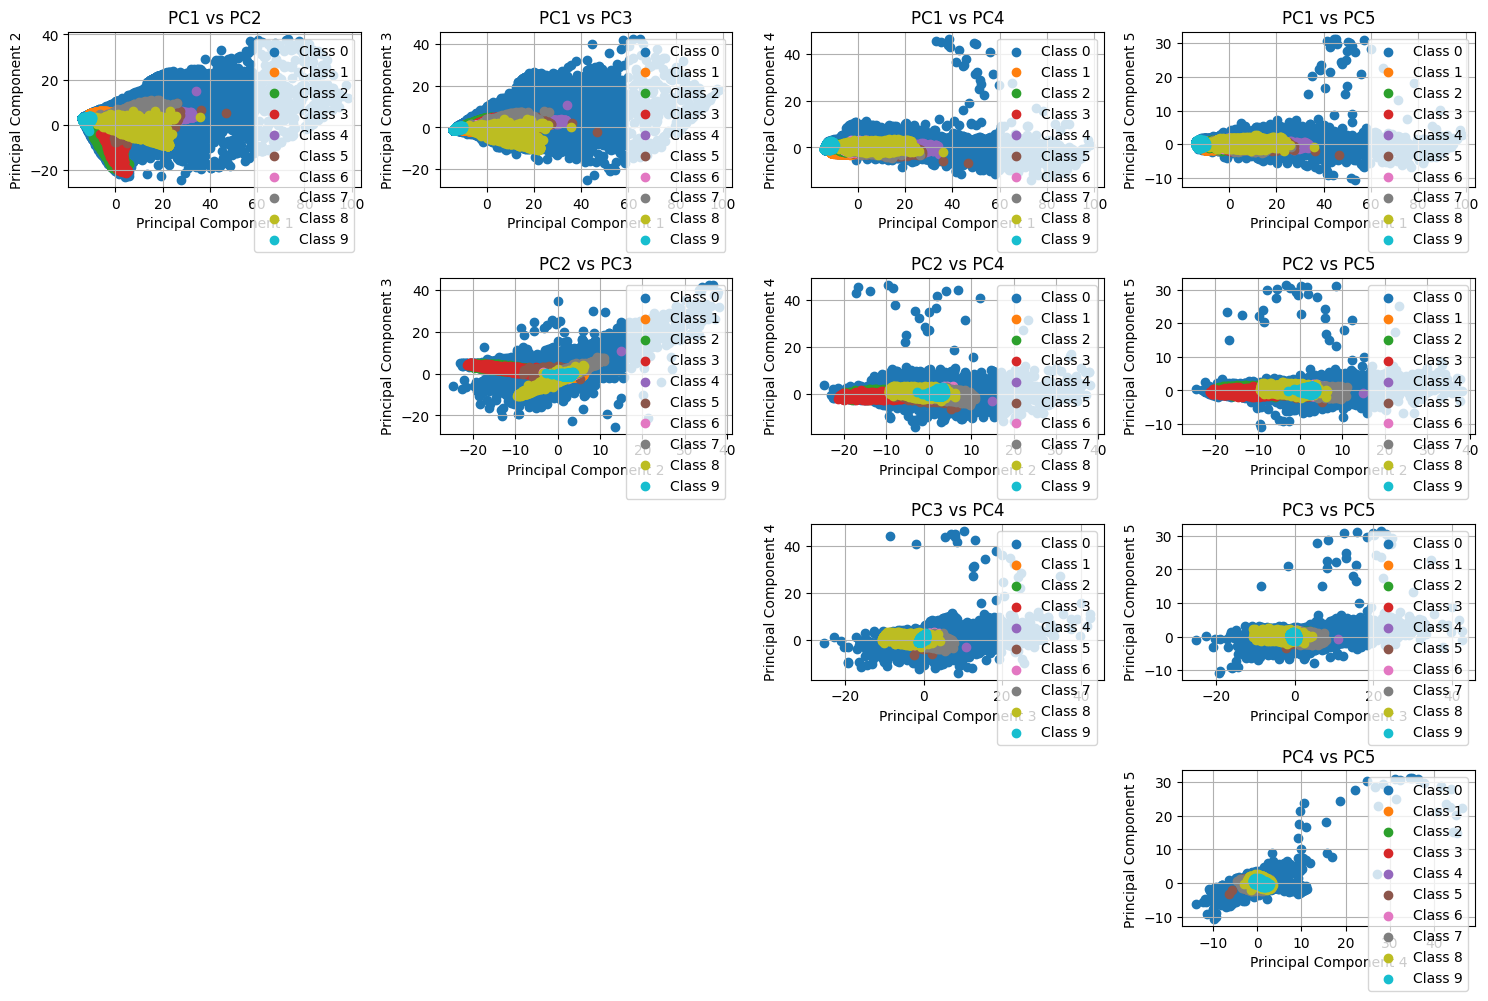

In [ ]:
# Visualize the data after PCA
num_components = 5
plt.figure(figsize=(15, 10))
for i in range(num_components):
    for j in range(i+1, num_components):
        plt.subplot(num_components-1, num_components-1, i*(num_components-1)+j)
        for k in range(len(np.unique(pavia_gt))):
            plt.scatter(pavia_centre_pca[pavia_gt == k, i], pavia_centre_pca[pavia_gt == k, j], label=f'Class {k}')
        plt.xlabel(f'Principal Component {i+1}')
        plt.ylabel(f'Principal Component {j+1}')
        plt.title(f'PC{i+1} vs PC{j+1}')
        plt.legend()
        plt.grid(True)
plt.tight_layout()
plt.show()


**Model Building**

In [ ]:

(train_pixels,test_pixels) = hyperdate.batch_select(70)





In [ ]:
(train_batch, train_labels) = get_2dimbatches(norm_data, train_pixels)
(test_batch, test_labels) = get_2dimbatches(norm_data, test_pixels)



In [ ]:
train_batch.shape


(103702, 2, 2, 1)

In [ ]:
train_batch.shape

(37034, 10, 10, 1)

In [ ]:
filters_1

64

In [ ]:
# Necessary imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

num_catg = 9

# Define model hyperparameters
kernel_size = (1, 1)
pool_size = (1, 1)
lr = 1e-3
l2_parm = 1e-3
batch_size = 32
filters_1 = 64
filters_2 = 32
filters_3 = 32
drop_rate = 0.35
units_1 = 128
units_2 = 128

# Input shape
input_shape = train_batch.shape[1:]

# Building a 3-D Convolutional network model
cnn_model = models.Sequential()

# conv_1
cnn_model.add(layer=layers.Conv2D(filters=filters_1,
                                  kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm),
                                  input_shape=train_batch.shape[1:]))

# max_pool_1
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size,
                                     strides=pool_size,
                                     padding='valid'))

# Zero padding to match the output size
cnn_model.add(layer=layers.ZeroPadding2D(padding=(0, 0)))

# conv_2
cnn_model.add(layer=layers.Conv2D(filters=filters_2,
                                  kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm)))

# max_pool_2
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size,
                                     strides=pool_size,
                                     padding='valid'))

# Zero padding to match the output size
cnn_model.add(layer=layers.ZeroPadding2D(padding=(0, 0)))

# conv_3
cnn_model.add(layer=layers.Conv2D(filters=filters_3, kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm)))

# flatten_1
cnn_model.add(layer=layers.Flatten())

# dropout_1
cnn_model.add(layer=layers.Dropout(drop_rate))

# dense_1
cnn_model.add(layer=layers.Dense(units=units_1, activation='relu'))

# dense_2
cnn_model.add(layer=layers.Dense(units=units_2, activation='relu'))

# dense_3 (output_layer)
cnn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 10, 64)        128       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 64)        0         
 D)                                                              
                                                                 
 zero_padding2d (ZeroPaddin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                        

**Model Compilation and Training**

In [ ]:
from keras import optimizers, losses, metrics


# Define the learning rate and batch size
lr = 1e-4
batch_size = 32

# Compiling the model
cnn_model.compile(optimizer=optimizers.RMSprop(learning_rate=lr),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])


# Training the model
history = cnn_model.fit(x=train_batch, y=train_labels, batch_size=batch_size,epochs=20, validation_data=(test_batch, test_labels), verbose=False)


In [ ]:
def plot_results(history):
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

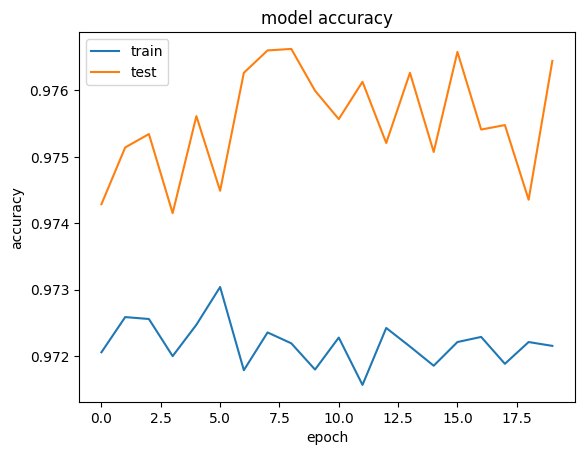

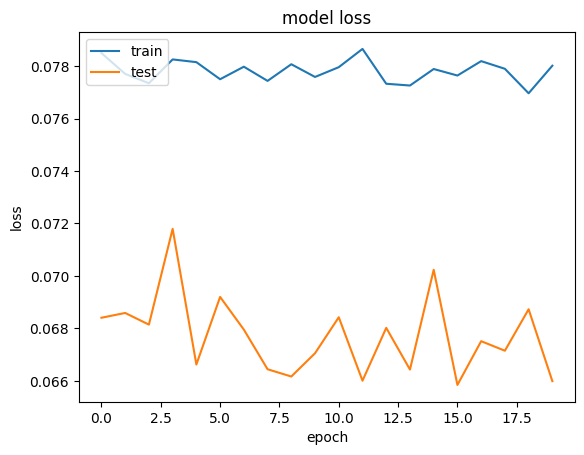

In [ ]:
#pca
plot_results(history)

In [ ]:
def get_batchs(input_data, label_select):
    # add paddings [145, 145, 200]
    Band = input_data.shape[2]
    kind = np.unique(label_select).shape[0]-1
    paddingdata = np.pad(input_data, ((3,3),(3,3),(0,0)), "edge")
    paddinglabel = np.pad(label_select, ((3,3),(3,3)), "constant")

    pixel = np.where(paddinglabel != 0)         #pixel = np.where(label_select != 0)
    #the number of batch
    num = np.sum(label_select != 0)
    batch_out = np.zeros([num, 7, 7, Band])
    batch_label = np.zeros([num, kind])
    for i in range(num):
        row_start = pixel[0][i]-3       #row_start = pixel[0][i]
        row_end = pixel[0][i]+4         #row_end = pixel[0][i]+7
        col_start = pixel[1][i]-3       #col_start = pixel[1][i]
        col_end = pixel[1][i]+4         #col_end = pixel[1][i]+7
        batch_out[i, :, :, :] = paddingdata[row_start:row_end, col_start:col_end, :]
        temp = (paddinglabel[pixel[0][i],pixel[1][i]]-1)    #temp = (label_selct[pixel[0][i],pixel[1][i]]-1)
        batch_label[i, temp] = 1

    batch_out = batch_out.swapaxes(1,3)
    batch_out = batch_out[:, :, :, :, np.newaxis]
    return batch_out, batch_label

In [ ]:
(train_batch, train_labels) = get_batchs(pavia_centre_pca, train_pixels)
(test_batch, test_labels) = get_batchs(pavia_centre_pca, test_pixels)



In [ ]:
# Necessary imports
from tensorflow.keras import layers, models, regularizers

num_catg = 9

# Define model hyperparameters
kernel_size = (1, 1, 5)   # 3-D convolutional layer kernel size
pool_size = (1, 1, 1)     # 3-D pooling kernel size
lr = 1e-3                 # learning rate
l2_parm = 1e-3            # L2 regularization parameter
batch_size = 2**5         # batch size for training model
filters_1 = 2**6          # Number of filters in the first convolutional layer
filters_2 = 2**5          # Number of filters in the second convolutional layer
filters_3 = 2**5          # Number of filters in the third convolutional layer
drop_rate = 0.35          # Drop rate in the 'dropout' layer
units_1 = 2**7            # Number of neurons in the first 'dense' layer
units_2 = 2**7            # Number of neurons in the second 'dense' layer

# Input shape
input_shape = train_batch.shape[1:]

# Building a 3-D Convolutional network model
cnn_model = models.Sequential()

# conv_1
cnn_model.add(layer=layers.Conv3D(filters=filters_1,
                                  kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm),
                                  input_shape=train_batch.shape[1:]))

# max_pool_1
cnn_model.add(layer=layers.MaxPool3D(pool_size=pool_size,
                                     strides=pool_size,
                                     padding='valid'))

# Zero padding to match the output size
cnn_model.add(layer=layers.ZeroPadding3D(padding=(0, 0, 2)))

# conv_2
cnn_model.add(layer=layers.Conv3D(filters=filters_2,
                                  kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm)))

# max_pool_2
cnn_model.add(layer=layers.MaxPool3D(pool_size=pool_size,
                                     strides=pool_size,
                                     padding='valid'))

# Zero padding to match the output size
cnn_model.add(layer=layers.ZeroPadding3D(padding=(0, 0, 2)))

# conv_3
cnn_model.add(layer=layers.Conv3D(filters=filters_3, kernel_size=kernel_size,
                                  strides=1, padding='valid',
                                  kernel_regularizer=regularizers.l2(l2_parm)))

# flatten_1
cnn_model.add(layer=layers.Flatten())

# dropout_1
cnn_model.add(layer=layers.Dropout(drop_rate))

# dense_1
cnn_model.add(layer=layers.Dense(units=units_1, activation='relu'))

# dense_2
cnn_model.add(layer=layers.Dense(units=units_2, activation='relu'))

# dense_3 (output_layer)
cnn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

cnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 6, 7, 3, 64)       384       
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 6, 7, 3, 64)       0         
 g3D)                                                            
                                                                 
 zero_padding3d_2 (ZeroPadd  (None, 6, 7, 7, 64)       0         
 ing3D)                                                          
                                                                 
 conv3d_5 (Conv3D)           (None, 6, 7, 3, 32)       10272     
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 6, 7, 3, 32)       0         
 g3D)                                                            
                                                      

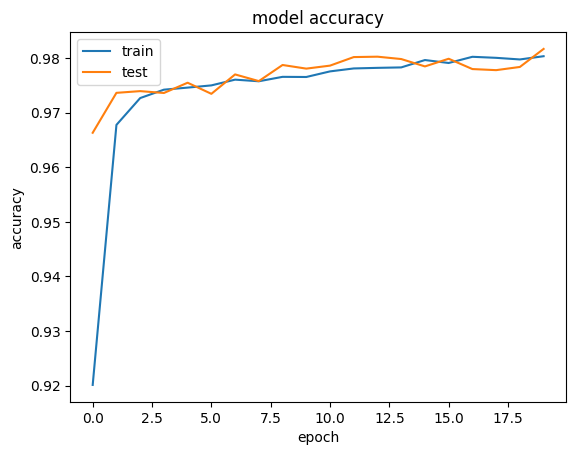

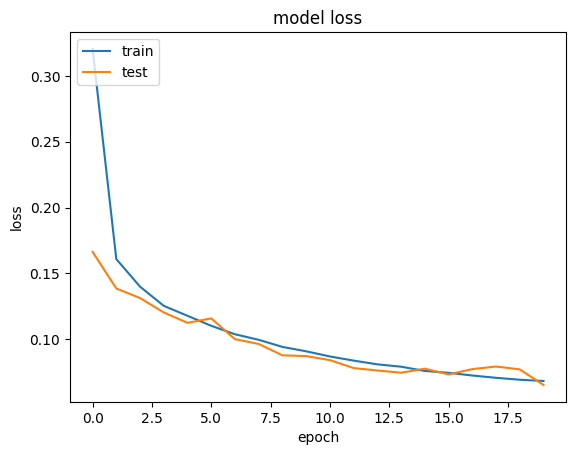

In [ ]:
plot_results(history)

**Model Evaluation**

In [ ]:
predictions = cnn_model.predict(test_batch)

1390/1390 [==============================] - 17s 12ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
def metrics(prediction, target, n_classes=None):
    """Compute and print metrics (accuracy, confusion matrix and F1 scores).

    Args:
        prediction: list of predicted labels
        target: list of target labels
        ignored_labels (optional): list of labels to ignore, e.g. 0 for undef
        n_classes (optional): number of classes, max(target) by default
    Returns:
        accuracy, F1 score by class, confusion matrix
    """


    results = {}

    n_classes = np.max(target) + 1 if n_classes is None else n_classes

    cm = confusion_matrix(
        target,
        prediction,
        labels=range(n_classes))

    results["Confusion matrix"] = cm

    # Compute global accuracy
    total = np.sum(cm)
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)

    results["Accuracy"] = accuracy

    # Compute F1 score
    F1scores = np.zeros(len(cm))
    for i in range(len(cm)):
        try:
            F1 = 2. * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i]))
        except ZeroDivisionError:
            F1 = 0.
        F1scores[i] = F1

    results["F1 scores"] = F1scores



    return results


In [ ]:
predictions

array([[9.99397397e-01, 3.85564090e-05, 1.47968720e-07, ...,
        7.17317016e-05, 1.14646426e-07, 4.84659075e-04],
       [9.99710917e-01, 1.71801967e-05, 5.80401114e-08, ...,
        2.14477768e-05, 2.81973946e-08, 2.47727119e-04],
       [9.99952495e-01, 3.94513563e-06, 3.17210720e-08, ...,
        5.74828937e-06, 3.91485377e-09, 3.72578870e-05],
       ...,
       [1.18494107e-07, 9.96644735e-01, 3.34595283e-03, ...,
        2.24612407e-07, 1.22833006e-08, 5.15001011e-06],
       [5.73280488e-07, 9.85759437e-01, 1.41933989e-02, ...,
        1.31414208e-06, 6.71957991e-08, 1.27163166e-05],
       [1.86612112e-06, 9.97253358e-01, 2.71231402e-03, ...,
        1.30140154e-06, 7.66489876e-08, 2.73734604e-05]], dtype=float32)

In [ ]:
# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded test labels to class labels
true_labels = np.argmax(test_labels, axis=1)

# Calculate metrics using the predicted labels and true labels
run_results = metrics(predicted_labels, true_labels, n_classes=9)



In [ ]:
predicted_labels

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
true_labels

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
results=[]

In [ ]:
import numpy as np
from  keras import layers, models, regularizers, optimizers, losses, metrics
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_batch, test_labels, verbose=False)
print('Overall loss = {}'.format(test_loss))
print('Overall accuracy = {}\n'.format(test_accuracy))

# Calculate accuracy for each class
class_accuracy = {}
for class_id in range(num_catg):
    # Get the indices of samples belonging to the current class
    class_indices = np.where(np.argmax(test_labels, axis=1) == class_id)[0]
    # Extract the input and target tensors for the current class
    class_input = test_batch[class_indices]
    class_target = test_labels[class_indices]
    # Evaluate the model on the current class data
    class_loss, class_accuracy[class_id] = cnn_model.evaluate(class_input, class_target, verbose=False)

# Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for class_id, accuracy in class_accuracy.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(class_id, accuracy, 30*'_'))



Overall loss = 0.07118193805217743
Overall accuracy = 0.9782573580741882

Class ID     Accuracy
______________________________
 0            1.0000
______________________________
 1            0.9816
______________________________
 2            0.6273
______________________________
 3            0.6971
______________________________
 4            0.9666
______________________________
 5            0.9841
______________________________
 6            0.9226
______________________________
 7            0.9957
______________________________
 8            0.9991
______________________________


In [ ]:
#pca
import numpy as np
from  keras import layers, models, regularizers, optimizers, losses, metrics
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_batch, test_labels, verbose=False)
print('Overall loss = {}'.format(test_loss))
print('Overall accuracy = {}\n'.format(test_accuracy))

# Calculate accuracy for each class
class_accuracy = {}
for class_id in range(num_catg):
    # Get the indices of samples belonging to the current class
    class_indices = np.where(np.argmax(test_labels, axis=1) == class_id)[0]
    # Extract the input and target tensors for the current class
    class_input = test_batch[class_indices]
    class_target = test_labels[class_indices]
    # Evaluate the model on the current class data
    class_loss, class_accuracy[class_id] = cnn_model.evaluate(class_input, class_target, verbose=False)

# Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for class_id, accuracy in class_accuracy.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(class_id, accuracy, 30*'_'))



Overall loss = 0.07950609177350998
Overall accuracy = 0.9727334380149841

Class ID     Accuracy
______________________________
 0            1.0000
______________________________
 1            0.9346
______________________________
 2            0.6915
______________________________
 3            0.7270
______________________________
 4            0.9459
______________________________
 5            0.9391
______________________________
 6            0.9140
______________________________
 7            0.9930
______________________________
 8            0.9965
______________________________


In [ ]:
#3CNN
import numpy as np
from  keras import layers, models, regularizers, optimizers, losses, metrics
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_batch, test_labels, verbose=False)
print('Overall loss = {}'.format(test_loss))
print('Overall accuracy = {}\n'.format(test_accuracy))

# Calculate accuracy for each class
class_accuracy = {}
for class_id in range(num_catg):
    # Get the indices of samples belonging to the current class
    class_indices = np.where(np.argmax(test_labels, axis=1) == class_id)[0]
    # Extract the input and target tensors for the current class
    class_input = test_batch[class_indices]
    class_target = test_labels[class_indices]
    # Evaluate the model on the current class data
    class_loss, class_accuracy[class_id] = cnn_model.evaluate(class_input, class_target, verbose=False)

# Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for class_id, accuracy in class_accuracy.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(class_id, accuracy, 30*'_'))



Overall loss = 0.0077789402566850185
Overall accuracy = 0.9976602792739868

Class ID     Accuracy
______________________________
 0            1.0000
______________________________
 1            0.9816
______________________________
 2            0.9655
______________________________
 3            0.9876
______________________________
 4            1.0000
______________________________
 5            0.9960
______________________________
 6            0.9963
______________________________
 7            0.9999
______________________________
 8            1.0000
______________________________


In [ ]:

def show_results(results,  label_values=None):



        cm = results["Confusion matrix"]
        accuracy = results["Accuracy"]
        F1scores = results["F1 scores"]


        text=""
        text += "Accuracy : {:.03f}%\n".format(accuracy)
        text += "---\n"

        text += "F1 scores :\n"


        for label, score in zip(label_values, F1scores):
            text += "\t{}: {:.03f}\n".format(label, score)
        text += "---\n"
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_values, yticklabels=label_values)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()





        print(text)


In [ ]:
label_values = [

            "Water",
            "Trees",
            "Asphalt",
            "Self-Blocking Bricks",
            "Bitumen",
            "Tiles",
            "Shadows",
            "Meadows",
            "Bare Soil",
        ]

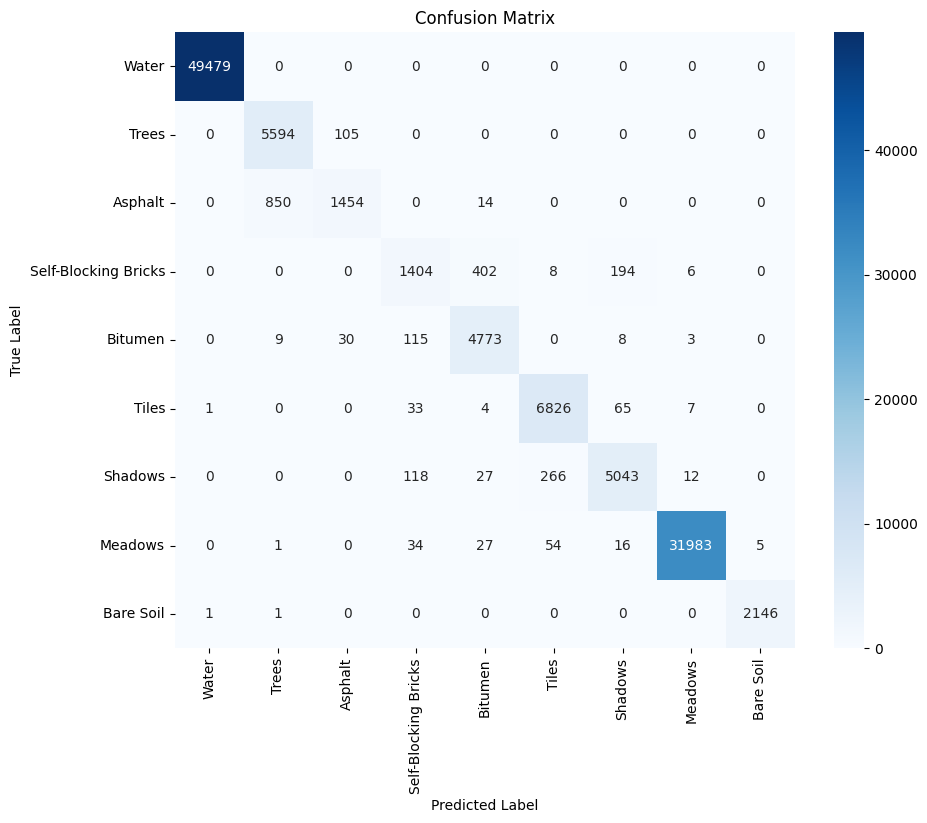

Accuracy : 97.826%
---
F1 scores :
	Water: 1.000
	Trees: 0.921
	Asphalt: 0.744
	Self-Blocking Bricks: 0.755
	Bitumen: 0.937
	Tiles: 0.969
	Shadows: 0.935
	Meadows: 0.997
	Bare Soil: 0.998
---



In [ ]:
results.append(run_results)
show_results(run_results, label_values=label_values)

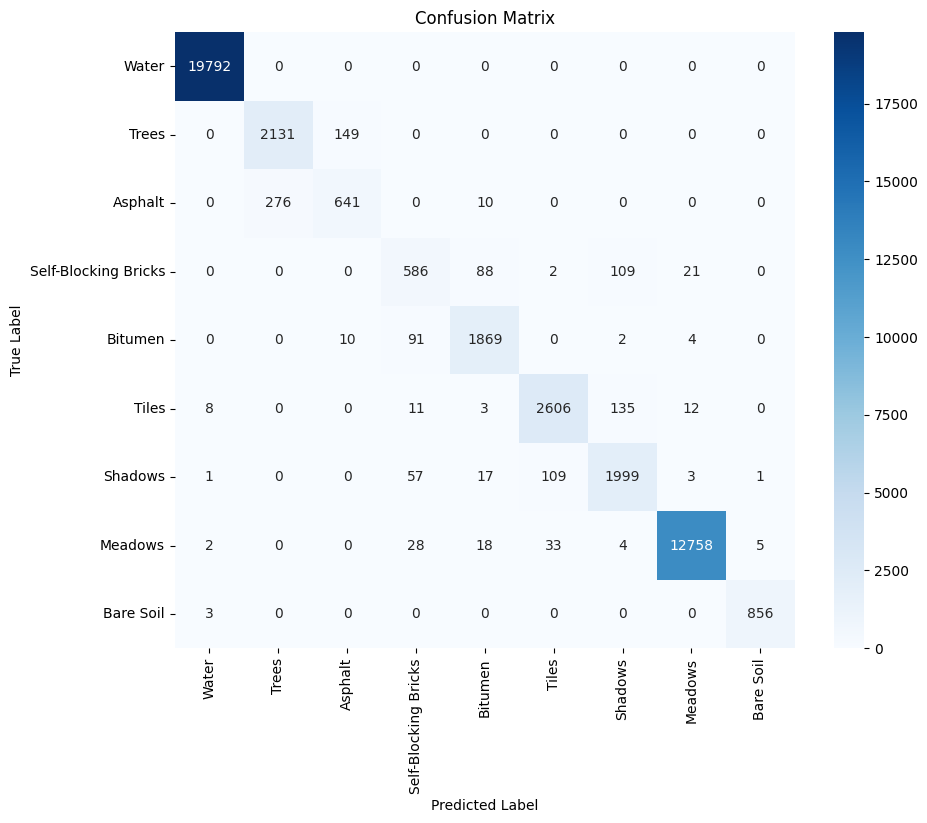

Accuracy : 97.273%
---
F1 scores :
	Water: 1.000
	Trees: 0.909
	Asphalt: 0.742
	Self-Blocking Bricks: 0.742
	Bitumen: 0.939
	Tiles: 0.943
	Shadows: 0.901
	Meadows: 0.995
	Bare Soil: 0.995
---



In [ ]:
#pca
results.append(run_results)
show_results(run_results, label_values=label_values)

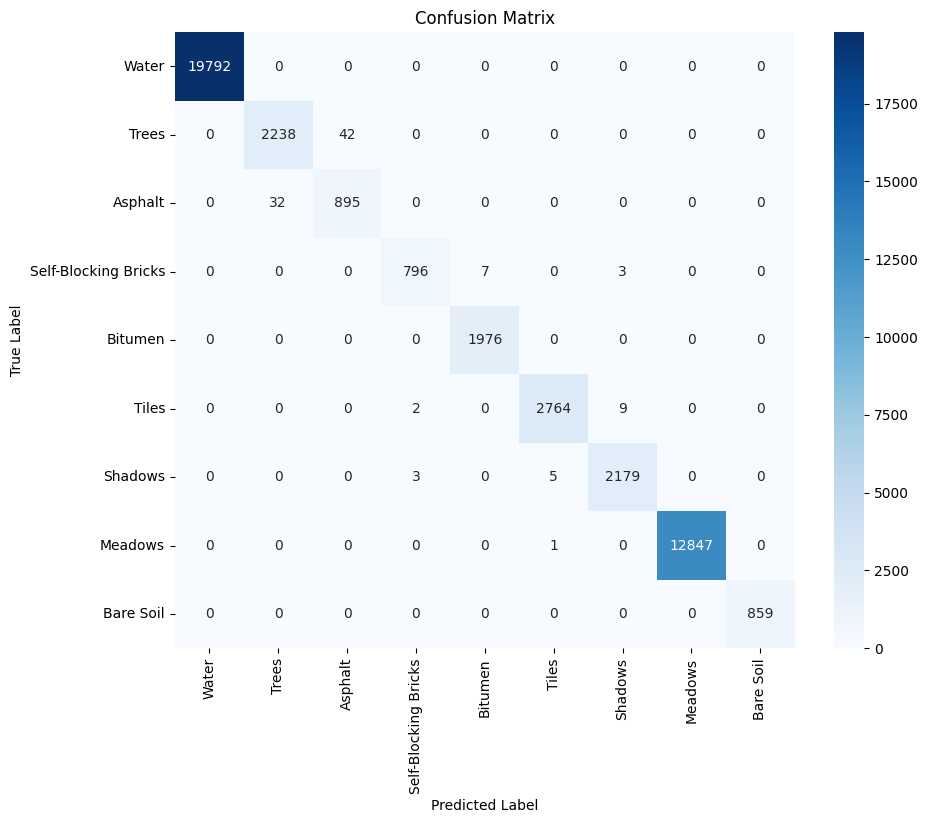

Accuracy : 99.766%
---
F1 scores :
	Water: 1.000
	Trees: 0.984
	Asphalt: 0.960
	Self-Blocking Bricks: 0.991
	Bitumen: 0.998
	Tiles: 0.997
	Shadows: 0.995
	Meadows: 1.000
	Bare Soil: 1.000
---



In [ ]:
#3D
results.append(run_results)
show_results(run_results, label_values=label_values)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
